In [2]:
from dotenv import load_dotenv
from textwrap import dedent

load_dotenv()

True

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

menu_db = Chroma(
    embedding_function=embeddings_model,
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [5]:
from langchain_core.tools import tool
from typing import List

@tool
def search_menu(query: str) -> List[str]:
    """
    레스토랑 메뉴에서 정보를 검색합니다.
    """

    docs = menu_db.similarity_search(query, k=2)

    formatted_docs = "\n---\n".join([
        f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
        for doc in docs
        ])
       
    if len(formatted_docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."  



In [7]:
from langchain_community.tools import TavilySearchResults

@tool
def search_web(query: str) -> str:
    """ 
    데이터베이스에 존재하지 않는 정보또는 최신 정보를 인터넷으로 검색합니다.
    """

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n---\n".join([
        f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
        for doc in docs
        ])
       
    if len(formatted_docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다." 



In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

tools = [search_menu, search_web]

llm_with_tools = llm.bind_tools(tools=tools)

In [9]:
from langchain_core.messages import AIMessage, HumanMessage

tool_call = llm_with_tools.invoke([HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")])

print(tool_call)

content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_r7nsrHroGEOhxepWRJH7kP8r', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e665f7564b'} id='run--d6cee01a-c2f2-465e-ae21-1b0b8ea7f03f-0' tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_r7nsrHroGEOhxepWRJH7kP8r', 'type': 'tool_call'}]


In [10]:
tool_call = llm_with_tools.invoke([HumanMessage("Langgraph는 무엇인가요?")])

print(tool_call)

content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_SxSIQ6e0O94SN1Tcn6GYKMCV', 'function': {'arguments': '{"query":"Langgraph"}', 'name': 'search_web'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e665f7564b'} id='run--0001e78b-9896-489c-a265-8e765786c34b-0' tool_calls=[{'name': 'search_web', 'args': {'query': 'Langgraph'}, 'id': 'call_SxSIQ6e0O94SN1Tcn6GYKMCV', 'type': 'tool_call'}]


In [11]:
tool_call = llm_with_tools.invoke([HumanMessage("3+4는 얼마인가요?")])

print(tool_call)

content='3 + 4는 7입니다.' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e665f7564b'} id='run--7b054ab2-b65b-4abe-980c-59c321949248-0'


In [12]:
# 도구노드(Tool Node) : LLM 이 요청한 (tool)  호출을 실행하는 역할을 처리
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)

In [14]:
tool_call = llm_with_tools.invoke([HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_e6CJI1nFeArNeVhtqMaxMWFD', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e665f7564b'}, id='run--c5835429-c6ad-4eaf-9239-0b33ccf17026-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_e6CJI1nFeArNeVhtqMaxMWFD', 'type': 'tool_call'}])

In [17]:
results = tool_node.invoke({"messages": [tool_call]})

results

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


{'messages': [ToolMessage(content='<Document href="./data/restaurant_menu.txt"/>\n8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.\n</Document>\n---\n<Document href="./data/restaurant_menu.txt"/>\n7. 랍스터 비스크\n   • 가격: ₩28,000\n   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카\n   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.\n</Document>', name='search_menu', tool_call_id='call_e6CJI1nFeArNeVhtqMaxMWFD')]}

In [18]:
for result in results["messages"]:
    print(result.content)
    print()

<Document href="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>



In [19]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    model=llm,
    tools=tools
)

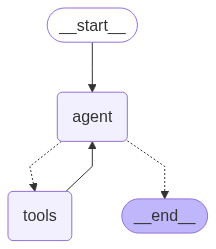

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
inputs ={
    "messages":[
        HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_61Se0xWhK9I9gWjihy9EDEvg)
 Call ID: call_61Se0xWhK9I9gWjihy9EDEvg
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴의 가격은 다음

In [22]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class GraphState(MessagesState):#messages 속성
    pass

In [27]:
system_prompt = dedent("""
You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크
    
    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question. 
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
Do not provide any information without a corresponding citation.
""")

In [28]:
def call_mode(state: GraphState) -> GraphState:
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages) #tool_calls

    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return "execute_tools"
    
    return END

In [29]:
builder = StateGraph(GraphState)
builder.add_node("call_mode", call_mode)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_mode")
builder.add_conditional_edges(
    "call_mode",
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)

builder.add_edge("execute_tools", "call_mode")
graph = builder.compile();

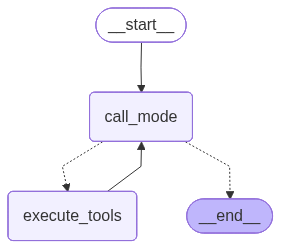

In [30]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
inputs ={
    "messages":[
        HumanMessage("파스타에 어울리는 음료는 무엇인가요?")
        #HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")
    ]
}

messages = graph.invoke(inputs)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

파스타에 어울리는 음료는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_NMAx4pr81WrGnEvg8f0jXuI9)
 Call ID: call_NMAx4pr81WrGnEvg8f0jXuI9
  Args:
    query: 파스타 음료
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스러운 향을 더했습니다. 파슬리를 곱게 다져 고명으로 올려 제공됩니다.
</Document>
================================== Ai Message ===============================

In [33]:
inputs ={
    "messages":[
        HumanMessage("방금 답변에 대한 출처가 있나요?")        
    ]
}

messages = graph.invoke(inputs)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

방금 답변에 대한 출처가 있나요?
================================== Ai Message ==================================

제가 제공하는 모든 정보는 반드시 출처가 포함되어야 합니다. 만약 제가 답변을 드렸다면, 그 답변에 대한 출처를 명시했을 것입니다. 특정 질문에 대한 이전 답변이나 출처가 필요하시면 질문해 주시면 그에 대해 다시 확인해 드리겠습니다.


In [34]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_memory = builder.compile(checkpointer=memory)

In [35]:
config = {"configurable": {"thread_id": "1"}}

inputs ={
    "messages":[
        HumanMessage("파스타에 어울리는 음료는 무엇인가요?")
    ]
}

messages = graph_memory.invoke(inputs, config)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

파스타에 어울리는 음료는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_eKrgjbp72SzxFGtjG4cvEXbC)
 Call ID: call_eKrgjbp72SzxFGtjG4cvEXbC
  Args:
    query: 파스타 음료
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스러운 향을 더했습니다. 파슬리를 곱게 다져 고명으로 올려 제공됩니다.
</Document>
================================== Ai Message ===============================

In [36]:
config = {"configurable": {"thread_id": "1"}}

inputs ={
    "messages":[
        HumanMessage("여러 개 중 저렴한 메뉴는 무엇인가요?")
    ]
}

messages = graph_memory.invoke(inputs, config)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

파스타에 어울리는 음료는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_eKrgjbp72SzxFGtjG4cvEXbC)
 Call ID: call_eKrgjbp72SzxFGtjG4cvEXbC
  Args:
    query: 파스타 음료
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스러운 향을 더했습니다. 파슬리를 곱게 다져 고명으로 올려 제공됩니다.
</Document>
================================== Ai Message ===============================

In [37]:
# 챗봇 구현
import gradio as gr
from typing import List, Tuple
import uuid


memory = MemorySaver()

graph_memory = builder.compile(checkpointer=memory)

example_questions = [
    "채식주의자를 위한 메뉴를 추천해 주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?"
]

# 챗봇 답변 메시지 처리를 위한 함수
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        config = {"configurable": {"thread_id": thread_id}}
        inputs = {"messages": [HumanMessage(content=message)]}
        
        result = graph_memory.invoke(inputs, config)
        
        if "messages" in result:
            last_message = result["messages"][-1]
            if isinstance(last_message, AIMessage):
                return last_message.content
            
        return "응답을 처리하는 데 문제가 발생했습니다."
    except Exception as e:
        return f"오류가 발생했습니다: {str(e)}"
    
    
class Chatbot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        response = process_message(message, history, self.thread_id)        #
        return response
        
chatbot = Chatbot()

demo = gr.ChatInterface(
    fn=chatbot.chat,
    examples=example_questions,
    title="LangGraph 챗봇",
    description="레스토랑 메뉴에 대한 질문을 해보세요.",
    theme=gr.themes.Soft(),
)

demo.launch()

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-work-cwpQpvDj-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [38]:
demo.close()

Closing server running on port: 7860
